In [16]:
import pandas as pd
import seaborn as sns
import glob, os
import re
%matplotlib inline

# Notes about DF
- `is_generated` : (bool) is the simulated tree, note when false, GED is just a single 0, not a dict
- `is_original_bt_espresso` : (bool) run with kevin's algo
- `num_unique_nodes` : (int) number of unique node types within the tree
- `total_nodes` : (int) total number of nodes within the generated tree
- `num_sub_trees` : (int) total number of sub trees within the generated tree
- `unique_node_freq` : (dict<string, int>) dictionary of unique node to how many in the tree
- `graph_edit_distance` : (Series[dict<string,Obj>]) series of scores for each sim tree
- GED Example:
```python
"graph_edit_distance": [
    {
        "sim_tree_num": 0,
        "num_nodes_in_subtree": 6,
        "num_uniq_nodes_in_subtree": 4,
        "unique_node_dict": {
            "Inverter": 0,
            "Repeater": 0,
            "LAT Sequence": 0,
            "Sequence": 1,
            "Parallel Selector": 1,
            "Selector": 0,
            "Parallel": 0,
            "Action": 3,
            "Condition": 1
        },
        "score": 8.0
    },
    {
        "sim_tree_num": 1,
        "num_nodes_in_subtree": 3,
        "num_uniq_nodes_in_subtree": 2,
        "unique_node_dict": {
            "Inverter": 0,
            "Repeater": 0,
            "LAT Sequence": 0,
            "Sequence": 1,
            "Parallel Selector": 0,
            "Selector": 0,
            "Parallel": 0,
            "Action": 2,
            "Condition": 0
        },
        "score": 1.0
    },
    {
        "sim_tree_num": 2,
        "num_nodes_in_subtree": 9,
        "num_uniq_nodes_in_subtree": 5,
        "unique_node_dict": {
            "Inverter": 0,
            "Repeater": 1,
            "LAT Sequence": 0,
            "Sequence": 0,
            "Parallel Selector": 1,
            "Selector": 1,
            "Parallel": 0,
            "Action": 3,
            "Condition": 3
        },
        "score": 15.0
    }
]
```

In [175]:
expr_num_key = "expr_num"
unique_node_freq_key = "unique_node_freq"
ged_key = "graph_edit_distance"
is_gen_key = "is_generated"
is_orig_key = "is_original_bt_espresso"
score_key = "score"
sim_tree_num_key = "sim_tree_num"
score_diff_key = "score_diff"
tot_nodes_key = "total_nodes"

In [168]:
def getNumFromExprFilename(filename):
    numeric_filter = filter(str.isdigit, filename)
    return "".join(numeric_filter)

def expandDictCol(col_name):
    return pd.concat([df.drop([col_name], axis=1), df[col_name].apply(pd.Series)], axis=1)

results_path = "results/"
results = []
gen_trees = []
df = None
p = None
for filename in glob.glob(results_path + "*.json"):
    expr_num = getNumFromExprFilename(filename)
    df = pd.read_json(filename).T
    df = expandDictCol(unique_node_freq_key)
    p =  df[df[is_gen_key] == False]
    p[expr_num_key] = expr_num
    gen_trees.append(p)
    df = df.drop(p.index)
    df = df.explode(ged_key)
    df = expandDictCol(ged_key)
    df[expr_num_key] = expr_num
    results.append(df)
    
f_df = pd.concat(results, axis=0, ignore_index=True)
s_df = pd.concat(gen_trees, axis=0, ignore_index=True)

/var/folders/bq/77cqsbrj0nnfyn947ttr9bxm0000gn/T/ipykernel_35881/4029955584.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[expr_num_key] = expr_num


In [144]:
valid_score = f_df[score_key] >= 0

,is_generated,is_original_bt_espresso,num_unique_nodes,total_nodes,num_sub_trees,Inverter,Repeater,LAT Sequence,Sequence,Parallel Selector,...,Parallel,Action,Condition,sim_tree_num,num_nodes_in_subtree,num_uniq_nodes_in_subtree,unique_node_dict,score,expr_num,0
0,False,False,7,16,2,2,1,0,1,2,...,1,6,3,0.0,5.0,3.0,"{'Inverter': 0, 'Repeater': 0, 'LAT Sequence':...",9.0,28,NaN
1,False,False,7,16,2,2,1,0,1,2,...,1,6,3,1.0,5.0,3.0,"{'Inverter': 0, 'Repeater': 1, 'LAT Sequence':...",8.0,28,NaN
2,False,False,7,16,2,2,1,0,1,2,...,1,6,3,2.0,6.0,4.0,"{'Inverter': 0, 'Repeater': 1, 'LAT Sequence':...",7.0,28,NaN
129,False,False,7,16,2,4,1,0,1,0,...,1,3,5,0.0,5.0,3.0,"{'Inverter': 0, 'Repeater': 1, 'LAT Sequence':...",5.0,82,NaN
130,False,False,7,16,2,4,1,0,1,0,...,1,3,5,1.0,5.0,3.0,"{'Inverter': 0, 'Repeater': 1, 'LAT Sequence':...",8.0,82,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10477,False,False,6,22,2,6,1,0,2,0,...,0,3,7,2.0,6.0,4.0,"{'Inverter': 0, 'Repeater': 1, 'LAT Sequence':...",7.0,1,NaN
10544,False,False,7,19,2,3,2,0,0,1,...,1,5,5,NaN,NaN,NaN,NaN,NaN,6,0.0
10653,False,False,7,25,3,3,1,0,3,1,...,0,7,7,0.0,5.0,3.0,"{'Inverter': 0, 'Repeater': 1, 'LAT Sequence':...",9.0,49,NaN
10654,False,False,7,25,3,3,1,0,3,1,...,0,7,7,1.0,6.0,3.0,"{'Inverter': 0, 'Repeater': 0, 'LAT Sequence':...",10.0,49,NaN


In [180]:
tmp_m = f_df[valid_score].groupby([expr_num_key, is_orig_key, sim_tree_num_key])["score"].min()
tmp_m = tmp_m.unstack(level=1)
# True = kevin
# False = RE:BT-Espresso
min_r = tmp_m[True] - tmp_m[False]
#min_r.index = ['{}_{}'.format(i, j) for i, j in min_r.index]
min_r = min_r.reset_index()
min_r = min_r.rename(columns={0 : score_diff_key})
tnn_s_df = s_df[["total_nodes", expr_num_key]]
minr = min_r.join(tnn_s_df.set_index(expr_num_key), on=expr_num_key)
fminr = minr[[tot_nodes_key, score_diff_key]]
sns.heatmap(fminr.groupby(tot_nodes_key))


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/matrix.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_data = np.asarray(data)


ValueError: setting an array element with a sequence.

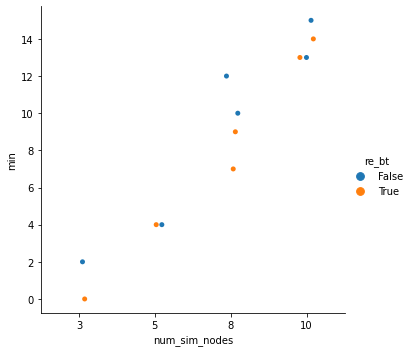

In [8]:
sns.catplot(x="num_sim_nodes", y="min", hue="re_bt", ci="std", data=result_df)

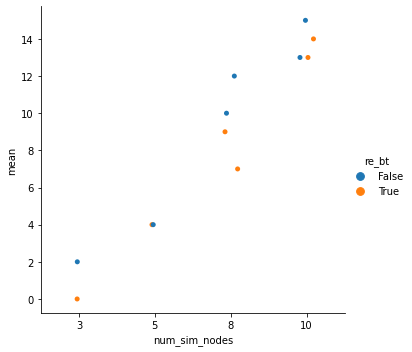

In [9]:
sns.catplot(x="num_sim_nodes", y="mean", hue="re_bt", data=result_df)